In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

#import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
#   for filename in filenames:
#      print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import numpy as np 
import pandas as pd 
import tensorflow as tf 
from tensorflow import keras
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import cv2
import os, glob, shutil

In [3]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:  
  try:
    tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
  except RuntimeError as e:
    print(e)

1 Physical GPUs, 1 Logical GPU


2021-12-15 15:20:36.026341: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-15 15:20:36.114417: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-15 15:20:36.115134: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-15 15:20:36.117653: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [4]:
input_dir='/kaggle/input/food41/images'

In [5]:
glob_dir = input_dir + '/*/*.jpg'

temp  = glob.glob(glob_dir)

print(len(temp))

101000


In [6]:
x=temp[0:200]
paths = [file for file in x]
images = [cv2.resize(cv2.imread(file), (224, 224)) for file in x]
images = np.array(np.float32(images).reshape(len(images),images[0].shape[0],images[0].shape[1],images[0].shape[2])/255)

In [7]:
images.shape

(200, 224, 224, 3)

In [8]:
## embedding
model = tf.keras.applications.MobileNetV2(include_top = False, weights='imagenet', input_shape=(224, 224, 3))
predictions = model.predict(images.reshape(-1, 224, 224, 3)) ## representation of image to reduce size
pred_images = predictions.reshape(images.shape[0], -1) ## reshape

9420800/9406464 [==============================] - 0s 0us/step


2021-12-15 15:21:04.761662: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2021-12-15 15:21:06.115814: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


In [9]:
predictions.shape

(200, 7, 7, 1280)

In [10]:
pred_images.shape

(200, 62720)

In [11]:
#### Plotting Silhoutte score to find optimal K
sil = []
kl = []
kmax = 14
#kmax = 14



for k in range(2, kmax+1):
  print(k)
  kmeans2 = KMeans(n_clusters = k).fit(pred_images)
  labels = kmeans2.labels_
  sil.append(silhouette_score(pred_images, labels, metric = 'euclidean'))
  kl.append(k)

2
3
4
5
6
7
8
9
10
11
12
13
14


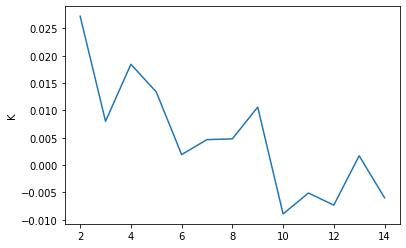

In [12]:
plt.plot(kl,sil)
plt.ylabel('Silhoutte Score')
plt.ylabel('K')
plt.show()

In [13]:
#### Concluding K = 9 from observation 
#### And using this value to train K-means model
k = 9
kmodel = KMeans(n_clusters=k, n_jobs=-1, random_state = 0) #change random state any value

kmodel.fit(pred_images) ### training kmean


kpredictions = kmodel.predict(pred_images) ###prediction
####

/opt/conda/lib/python3.7/site-packages/sklearn/cluster/_kmeans.py:939: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  " removed in 0.25.", FutureWarning)


In [14]:
#### Making output directory
for i in range(k):
    if(os.path.isdir("/kaggle/working/cluster" + str(i))==False):
        os.makedirs("/kaggle/working/cluster" + str(i))
    #print(i)
    ## for making directory
    
    
    ## Saving images in directory
for i in range(len(paths)):
    shutil.copy2(paths[i], "/kaggle/working/cluster"+str(kpredictions[i]))
####

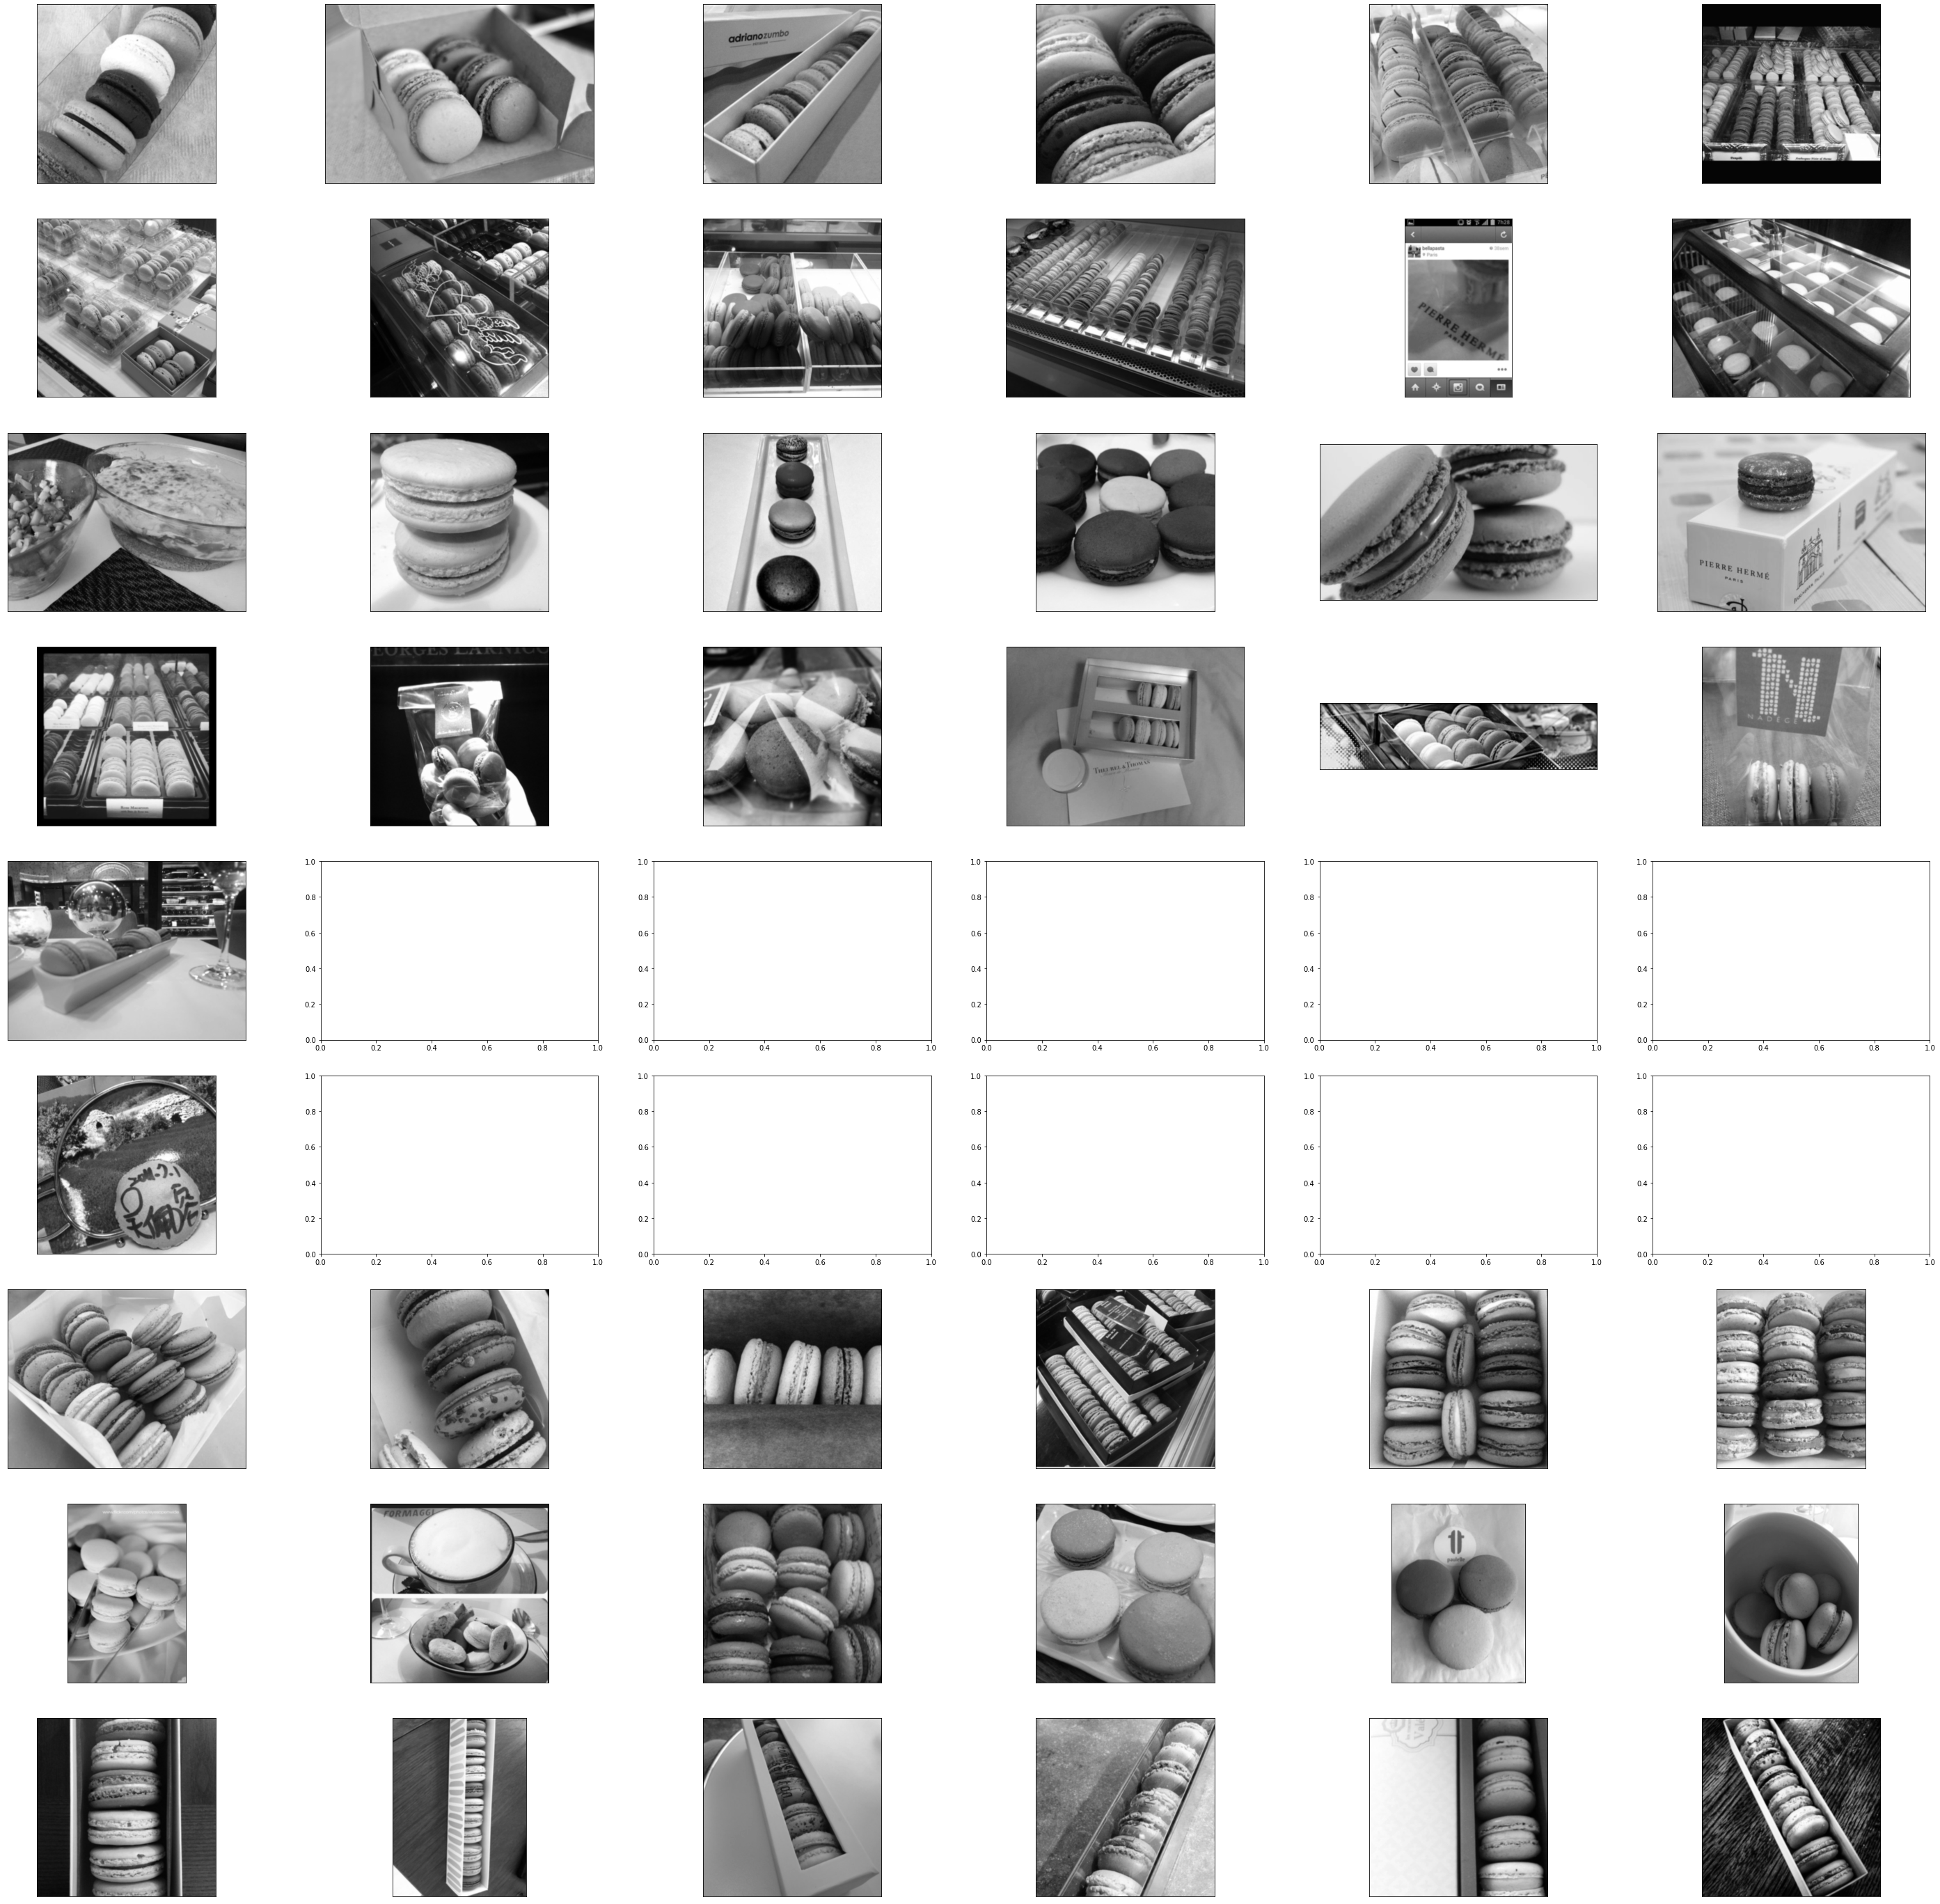

In [15]:
#### Plotting image from each cluster
fig ,axs = plt.subplots(k,6,figsize=(50,50)) ### making subplot 

for i in range(k):
    xyz = '/kaggle/working/cluster'+str(i) + '/*.jpg'
    img = [cv2.imread(abc,0) for abc in glob.glob(xyz)]
    
    
    #print("Cluster No "+str(i))
    for j in range(min(6, len(img))):
      axs[i][j].imshow(img[j], cmap = 'gray', interpolation = 'bicubic')
      axs[i][j].set_xticks([])
      axs[i][j].set_yticks([])
####